TO DO: rename so it is clear it only computes with spectral + date features

In [2]:
import os
import time
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

import model_prep_and_evals as mpe 
import A_data_sampling_workflow.sample_rasters as sr

from shapely.geometry import Polygon

In [10]:
# **************************************************************
root = '/home/jovyan/msai4earth-esa/iceplant_detection/models/model_2k/twok_dataset/dataset_2500/initial_dataset'
train_name = 'train_2500.csv'
test_name = 'test_2500.csv'

label_name = 'iceplant'

# ------------------------------
# IMPORT TRAIN DATA
X_train = pd.read_csv(os.path.join(root, train_name))
y_train = pd.read_csv(os.path.join(root, train_name)).loc[:,label_name] 
y_train = y_train.to_numpy()

# ------------------------------
# IMPORT TEST DATA
X_test = pd.read_csv(os.path.join(root, test_name))
y_test = pd.read_csv(os.path.join(root, test_name)).loc[:,label_name] 
y_test = y_test.to_numpy()

# ------------------------------
bands = ['r','g','b','nir','ndvi']

In [5]:
def classify_iceplant(raster, rfc, cols):
    is_veg, water_index, not_veg_index = sr.add_spectral_features(df =sr.raster_as_df(raster.to_numpy(), ['r','g','b','nir']), #names of bands
                                                               ndwi_thresh = 0.3, 
                                                               ndvi_thresh = 0.05) 
    # ---------------------------------------
    # select features
    is_veg.drop('ndwi', axis=1, inplace=True)
    is_veg = sr.add_date_features(is_veg, raster.datetime)

    classify = is_veg[cols].to_numpy()

    # ---------------------------------------
    # predict using model
    preds = rfc.predict(classify)    

    # ---------------------------------------
    # recover pixel indices for iceplant classifications
    preds_df = pd.DataFrame(preds, 
                         columns=['is_iceplant'], 
                         index = is_veg.index)
    is_iceplant_index = preds_df[preds_df.is_iceplant == 1].index.to_numpy()
    non_iceplant_index = preds_df[preds_df.is_iceplant == 0].index.to_numpy()

    # ---------------------------------------
    # reconstruct indices into image
    indices = [non_iceplant_index,
               is_iceplant_index, 
               not_veg_index,
               water_index]
    values = [0,    # values assigned to pixels from each index
              1,
              3,    # *** CHANGED THIS TO HAVE  difference of +-2 in change detection ***
              3]
    reconstruct = sr.indices_to_image(raster.shape[1], raster.shape[2], indices, values, back_value=100)
    return reconstruct

In [6]:
# =====================================================
# Conception
box_conc = Polygon([
            [-120.460475016992,34.458719091893286],
            [-120.460475016992,34.457914336783816],
            [-120.4595085784309,34.457914336783816],
            [-120.4595085784309,34.458719091893286],
            [-120.460475016992,34.458719091893286]
          ])

itemid_conc = 'ca_m_3412037_nw_10_060_20200607'
# =====================================================
# Downtown Santa Barbara
box_dtwn = Polygon([
            [-119.68421454977785,34.41470061879498],
            [-119.68421454977785,34.413873204306356],
            [-119.68319471307942,34.413873204306356],
            [-119.68319471307942,34.41470061879498],
            [-119.68421454977785,34.41470061879498]
          ])
itemid_dtwn = 'ca_m_3411935_se_11_060_20200521'

# =====================================================
# Carpinteria

box_carp = Polygon( [
            [-119.5144546684841,34.39274397377842],
            [-119.5144546684841,34.39193499538564],
            [-119.51344346289721,34.39193499538564],
            [-119.51344346289721,34.39274397377842],
            [-119.5144546684841,34.39274397377842]
          ])
itemid_carp = 'ca_m_3411936_se_11_060_20200521'

# =====================================================
# Campus lagoon

box_campus = Polygon([
            [-119.84498486537822,34.405839218897256],
            [-119.84498486537822,34.40505175972115],
            [-119.84395933515827,34.40505175972115],
            [-119.84395933515827,34.405839218897256],
            [-119.84498486537822,34.405839218897256]
          ])
itemid_campus = 'ca_m_3411934_sw_11_060_20200521'

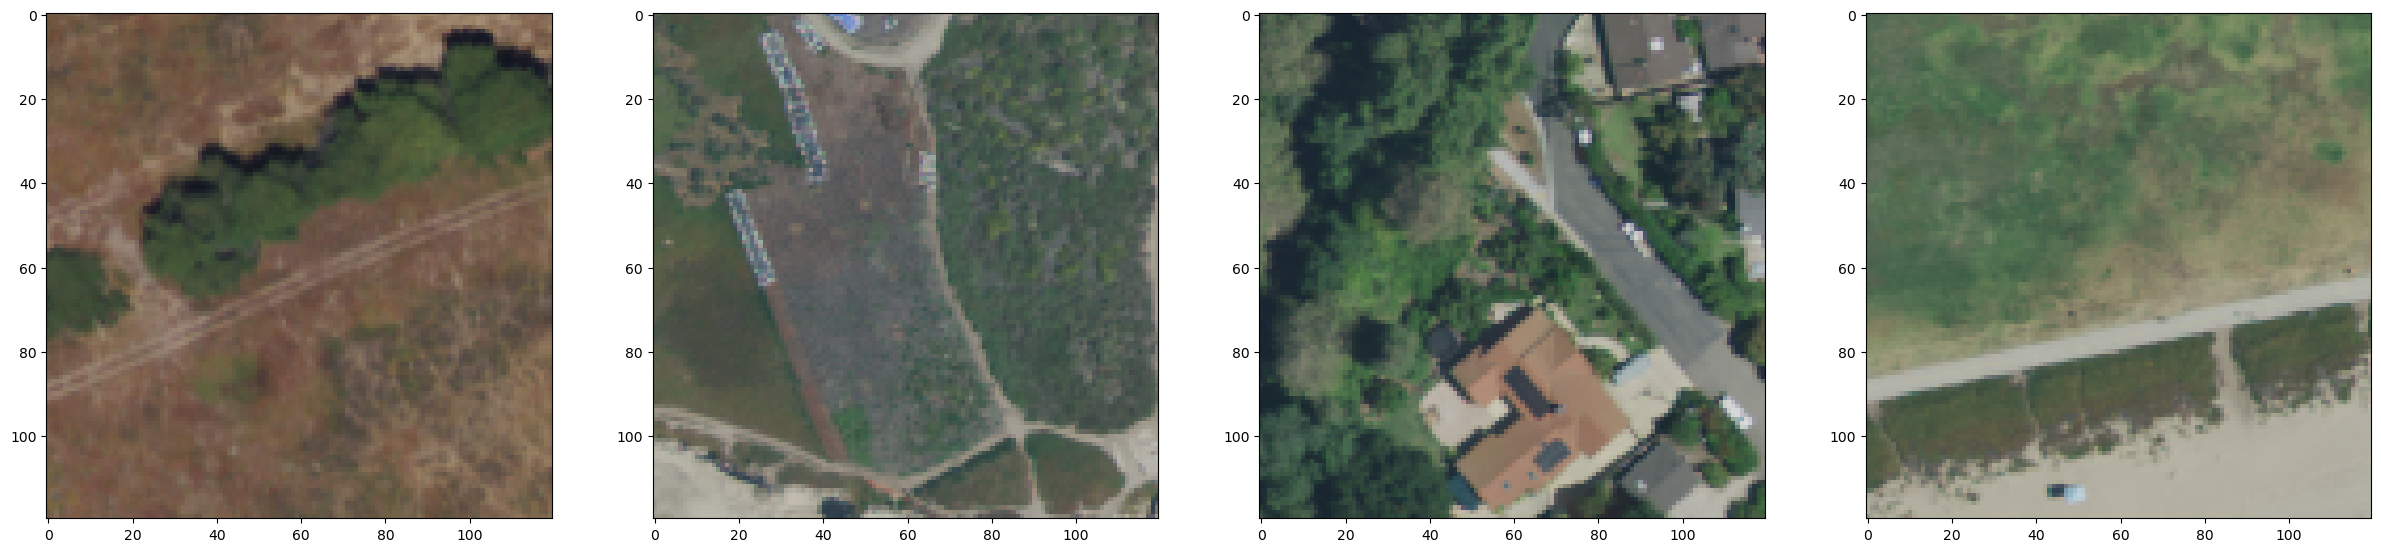

In [7]:
# Load rasters

boxes = [box_conc, box_campus, box_carp, box_dtwn]
itemids = [itemid_conc, itemid_campus, itemid_carp, itemid_dtwn]


# I already knew the aois are at least 150x150 pixels
rasters = []
for itemid, box in zip(itemids, boxes):
    rasters.append(sr.rioxr_from_itemid(itemid, box, "EPSG:4326")[:,0:150,0:150][:,16:136,16:136])
    # the second subset is selecting the region outside a 15 pixel buffer around all edges

fig, ax = plt.subplots(1,4,figsize=(30, 20))  
for i in range(4):
    ax[i].imshow(np.moveaxis(rasters[i].loc[1:3].to_numpy(),0,-1))
plt.show()

In [8]:
# feats is only a vector with the labels for the different models
images = []
feats = ['spectral','spectral+date','spectral+ndvi','spectral+ndvi+date']

for cols in [['r','g','b','nir'], 
             ['r','g','b','nir','month', 'day_in_year'], 
             bands, 
             bands + ['month', 'day_in_year']]:
    
    X_train_sub = X_train[cols].to_numpy()
    X_test_sub = X_test[cols].to_numpy()    

    rfc = RandomForestClassifier(n_estimators = 100, random_state = 42)
    rfc.fit(X_train_sub, y_train)

    this_model_imgs =[]
    for raster in rasters:
        this_model_imgs.append(classify_iceplant(raster, rfc, cols))

    images.append(this_model_imgs)
    print('done with ', cols)
    

done with  ['r', 'g', 'b', 'nir']
done with  ['r', 'g', 'b', 'nir', 'month', 'day_in_year']
done with  ['r', 'g', 'b', 'nir', 'ndvi']
done with  ['r', 'g', 'b', 'nir', 'ndvi', 'month', 'day_in_year']


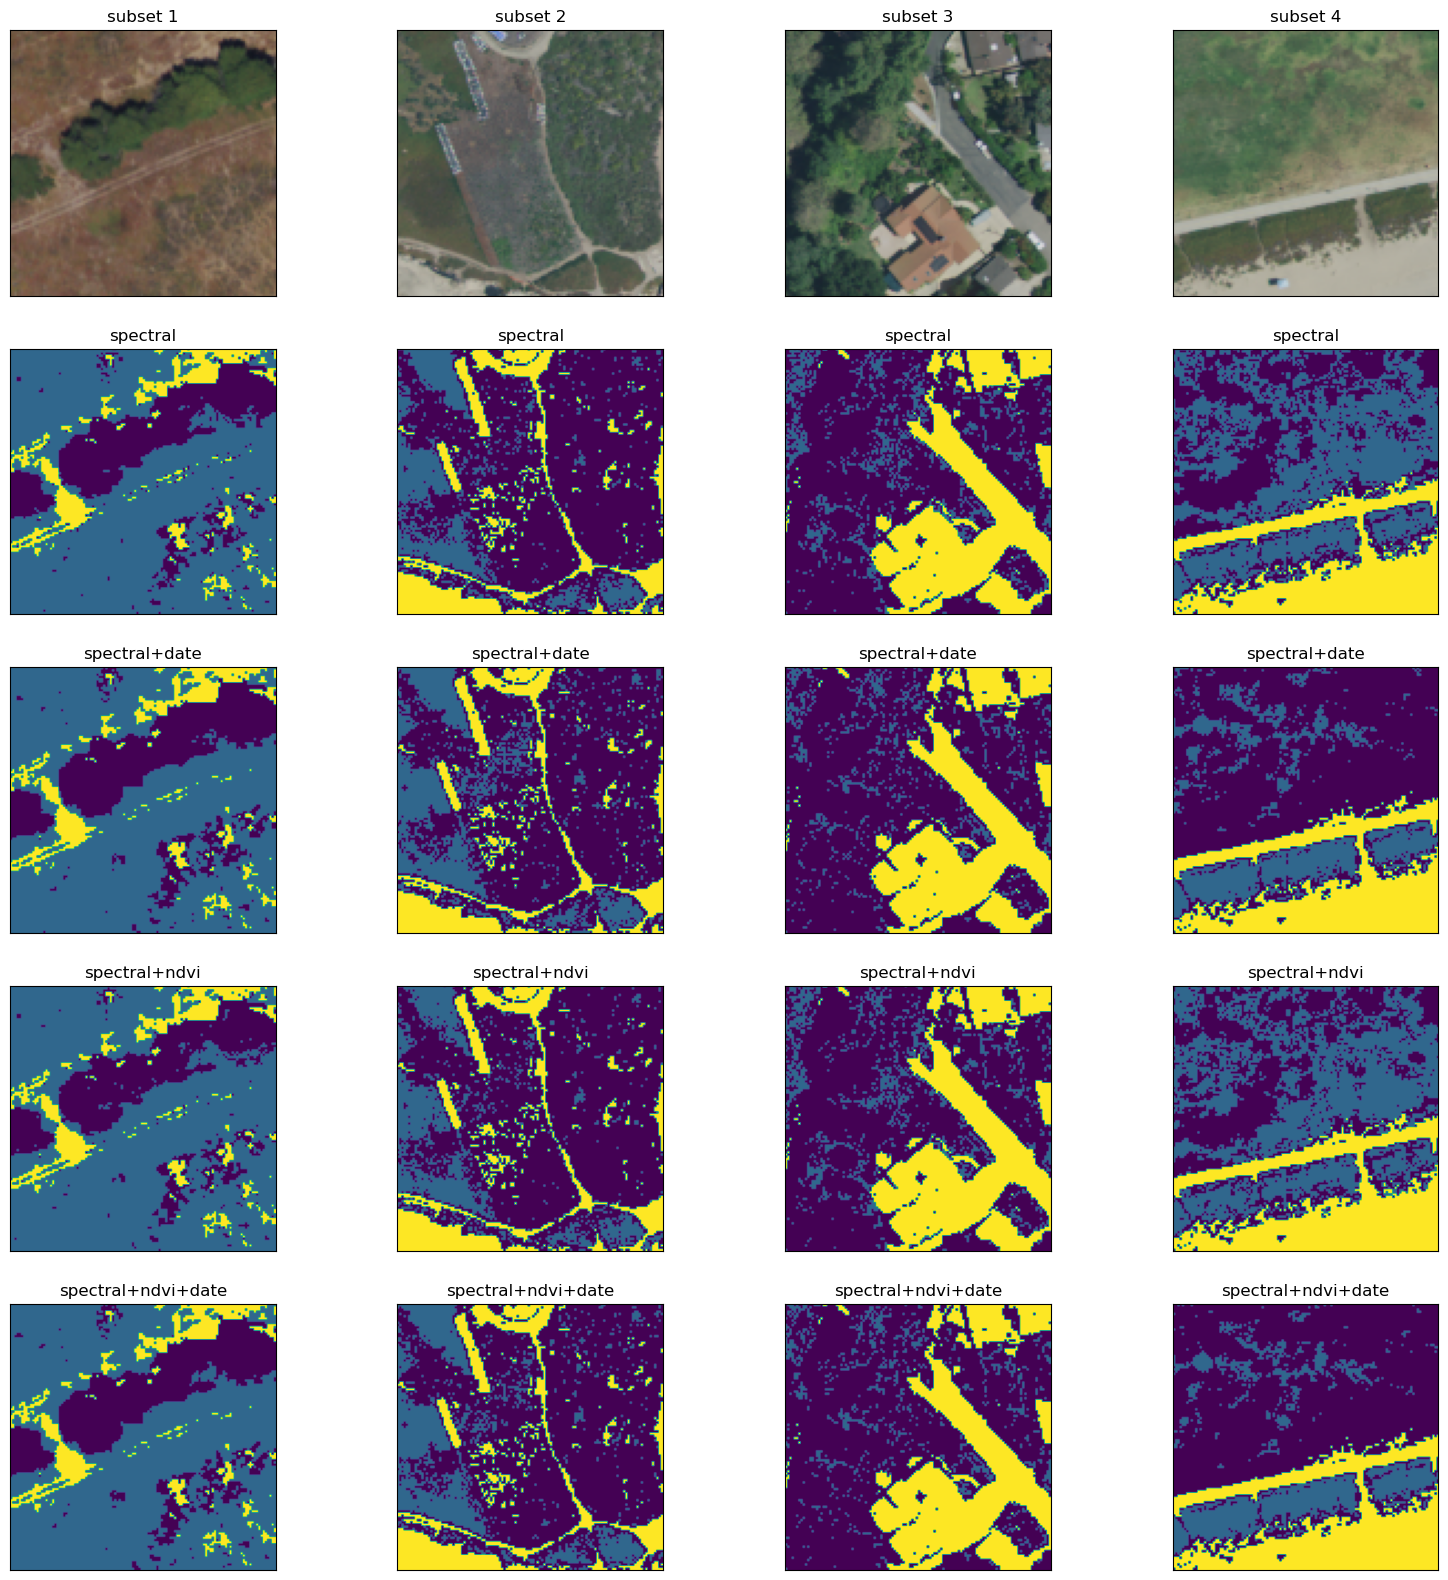

In [9]:
#fig, axes = plt.subplots(5,4,figsize=(30, 20), gridspec_kw = {'wspace':0, 'hspace':0})
fig, axes = plt.subplots(5,4,figsize=(20, 20))
plt.setp(axes, xticks=[], yticks=[])
#plt.tight_layout()

for i in range(4):
    axes[0,i].imshow(np.moveaxis(rasters[i].loc[1:3].to_numpy(),0,-1))
    axes[0,i].set_title('subset ' + str(i+1))

for i, title in zip(range(4), feats):
    for j in range(4):
        axes[i+1,j].imshow(images[i][j])
        axes[i+1,j].set_title(title)

fig.subplots_adjust(wspace=0)

plt.savefig('spectral_subset_classification_results.png', bbox_inches='tight')
plt.show()